# SUMMA Turbulence Scheme Conversion
### Testing of offline turbulence against Snoqualmie observations

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xr
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec

import turbpy

In [2]:
# Project directory
dir_proj = '/Users/karllapo/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')

# Data
dir_data = os.path.join(dir_proj, 'data')
dir_snq = os.path.join(dir_data, 'SNQ')
dir_scp = os.path.join(dir_data, 'SCP')

# Model output
dir_model_ouptut = os.path.join(dir_data, 'results')

# Apply to Snoqualmie Observations

## Read Snoqualmie Obs

In [3]:
## Read the formatted supporting snoqualmie obs
os.chdir(dir_snq)
support = xr.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

In [4]:
## Met variables
mHeight = 6.
scalarGroundSnowFraction  = 1.
soilRelHumidity = 1.

In [5]:
stab_titles = ['Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              ]

# Titles for output and xarray datasets
out_titles = {'Standard': 'standard',
               'Louis (b = 4.7)': 'louis',
               'Louis (b = 12)': 'louis_mod',
               'Louis (Ri capped, MJ98)': 'louis_cap',
               'MO (Holtslag/de Bruin)': 'HD88',
               'MO (Holtslag/de Bruin - capped)': 'HD88_cap',
               'MO (Beljaars/Holtslag)': 'BJ91',
               'MO (Webb - NoahMP)': 'webb_noah',
               'MO (Cheng/Brutsaert)': 'CB05',
             }

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        stab_dict[st]['monin_obukhov']['roughness_function'] = 'constant_z0'
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}
        
z0Ground = 0.0005


## Discriminate data?

Previously I had only used periods where snow was present and the winds were greater than 2m/s. I think neither of those are necessary discriminations, so I will leave them out, simulate everything, and see what the data holds.

In [6]:
ribulk = turbpy.bulkRichardson(support.T6 + 273.15 + 0.06,
                               support.Tsrf + 273.15,
                               support.WIND,
                               mHeight - support.Snowdepth)
ind = ribulk > 0

In [7]:
offLineCalcFlag = True  # Flag that toggles offline simulation, if False loads previous simulation results
if offLineCalcFlag: 
    sensible = xr.Dataset()
    sensible.coords['time'] = support.time[ind]

    for stab in stab_titles:
        print(stab)
        
        senHeatGround = np.ones(support.time[ind].size) * np.nan # sensible heat flux from ground surface (W m-2)

        # Loop over each time step with snow
        for n,d in enumerate(support.time[ind]):
            # Met data at Snoqualmie on the given date
            ds = support.sel(time=d)
            snowDepth = ds.Snowdepth  # (m)
            airVaporPress = ds.Vap_press_6  * 1000  # (kPa) -> (Pa)
            airTemp = ds.T6 + 273.15  # (C) -> (K)
            sfcTemp = ds.Tsrf + 273.15  # (C) -> (K)
            sfcVaporPress, _ = turbpy.conversionTools.satVapPress(sfcTemp)
            windspd = ds.WIND  # (m/s)

            if np.any(np.isnan([snowDepth, airTemp, sfcTemp, airVaporPress, sfcVaporPress, windspd])):
                continue
            else:
                # Offline Turbulence Package
                (_, _, senHeatGround[n], 
                 _, _, _) = turbpy.turbFluxes(airTemp, 101000,
                                              airVaporPress, windspd, sfcTemp,
                                              sfcVaporPress, snowDepth,
                                              6, param_dict=stab_dict[stab],
                                              z0Ground=z0Ground)
        
        out_name = out_titles[stab]
        sensible[out_name] = (('time'), senHeatGround)

    ########
    # Save sensible/latent offline
    os.chdir(dir_model_ouptut)
    sensible.to_netcdf('TF.SNQ.sensible_revisions.constant_small_z0.nc')


Standard
Louis (b = 4.7)
Louis (b = 12)
Louis (Ri capped, MJ98)
MO (Holtslag/de Bruin)
MO (Holtslag/de Bruin - capped)
MO (Beljaars/Holtslag)
MO (Webb - NoahMP)
MO (Cheng/Brutsaert)


I originally had some bad variable names here that messed up the netcdf4 engine when trying to write the results. I manually changed them and saved the simulated output. It _should_ work with the modified code above, but I have not tested.

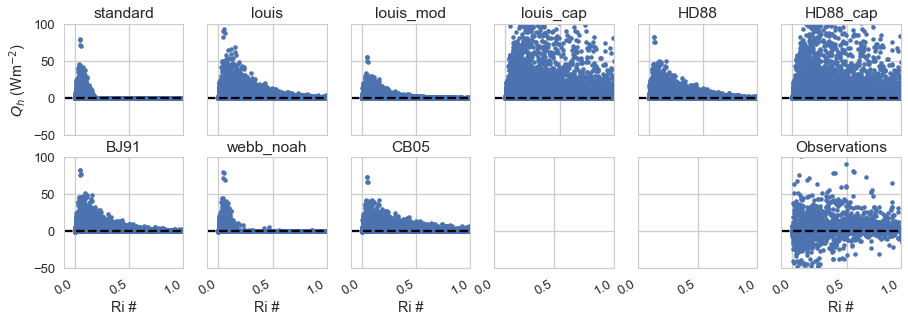

In [8]:
########
# Sensible
os.chdir(dir_print)
fig, axes = plt.subplots(2, 6, sharey=True, figsize=(15, 5))
axes = axes.flatten()
Qmax = 100
Qmin = -50
RiMax = 1.
RiMin = -0.1

for n, stab in enumerate(stab_titles):
    d = out_titles[stab]
    ax = axes[n]
    ax.plot(ribulk[ind], sensible[d], '.')
    ax.plot([RiMin, RiMax], [0, 0], 'k--')
    ax.set_xlim(RiMin, RiMax)
    ax.set_ylim(Qmin, Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(d)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(ribulk[ind], support.SensFlux[ind], '.')
ax.plot([RiMin, RiMax], [0, 0], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()


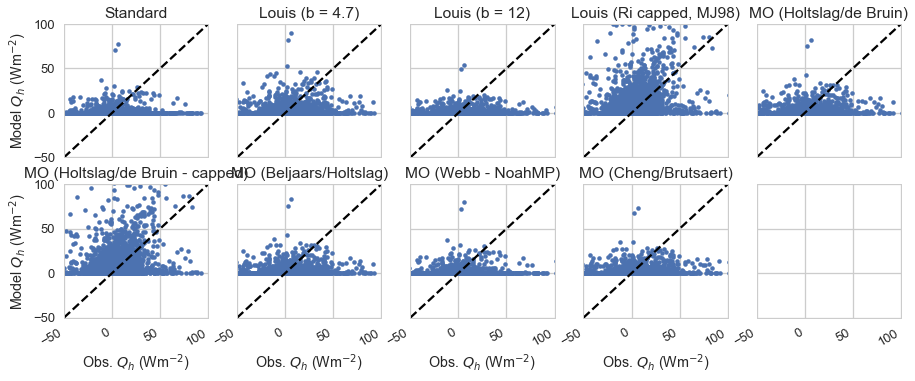

In [9]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dir_print)
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(15, 6))
axes = axes.flatten()
Qmax = 100
Qmin = -50

for n, stab in enumerate(stab_titles):
    d = out_titles[stab]
    ax = axes[n]
    ax.plot(support.SensFlux[ind], sensible[d], '.', label=stab)
    ax.plot([Qmin, Qmax],[Qmin, Qmax], '--k')
    ax.set_ylim(Qmin, Qmax)
    ax.set_xlim(Qmin, Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)
    
    if ax.is_first_col():
        ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')